# Deep Learning and machine Learning implementation. (part 1)

## Image loading and preparing the image matrices

## +++++++++++++++++++++++++++++++++++++++++++++

In [1]:

%matplotlib inline

import matplotlib.pyplot as plt
import os
import glob
import numpy as np

# I use skimage a class in scikit-image library for reading the images. Advantage of this
#  class over cv2 and pillow is that I can  readily change the dtype of the numpy array 
# elements into a float type. I need that to normalize the array.

from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.color import rgba2rgb, rgb2gray


import cv2
import keras

# I use the imageDataGenerator to create the augmented images
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


Using TensorFlow backend.


### Going through the train, validation and test directories and counting the number of images in them

In [2]:
director = ['train_images', 'test']

adress = '/home/paperspace/Desktop/InterviewExam'

for item in director:
    
    path, dirs, files = next(os.walk(os.path.join(adress,item)))
    s = '{}_file_count'.format(item)
    s = len(files)-1
    print('The {} directory has {} images'.format(item,s))

The train_images directory has 2000 images
The test directory has 184 images


In [3]:
# define functions that generate the augemnted images

def imgGen(img, zca=False, rotation=30., w_shift=0.,
           h_shift=0., shear=0., zoom=0., h_flip=False, v_flip=False,
           preprocess_fcn=None, batch_size=9):
    datagen = ImageDataGenerator(
            zca_whitening=zca,
            rotation_range=rotation,
            width_shift_range=w_shift,
            height_shift_range=h_shift,
            shear_range=shear,
            zoom_range=zoom,
            fill_mode='nearest',
            horizontal_flip=h_flip,
            vertical_flip=v_flip,
            preprocessing_function=preprocess_fcn,
            data_format=K.image_data_format())
    
    datagen.fit(img)

    i=0
    for img_batch in datagen.flow(img, batch_size=9, shuffle=False):
        for img in img_batch:
            plt.subplot(330 + 1 + i)
            plt.imshow(img)
            i=i+1    
        if i >= batch_size:
            break
    plt.show()
    
# Contrast stretching
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq


## visualization of a sample image and all augmented version of it

(150, 150, 4)


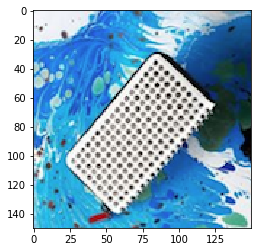

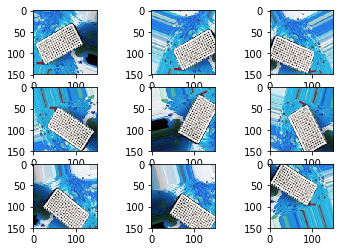

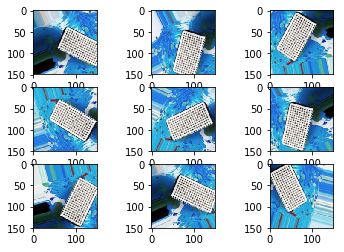

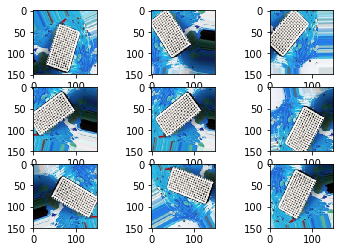

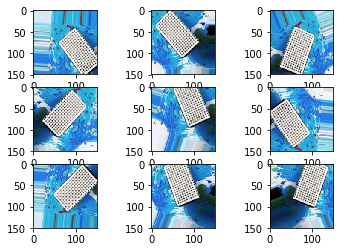

In [4]:
x_train_array_sample = np.array([])

# visualizing the image and its augmented version
# For simplicity here the for loop goes only loop once.

for file in sorted(glob.glob(os.path.join(adress,'test/0_2_026.png'))):
    image = imread(file)
    print(image.shape)
    height, width = image.shape[:2]
    
    plt.imshow(image)
    plt.show()
    
    image = image.astype('float32')
    image /=255
    
    # Check if the size of the input image is indeed 150X150 pixel. If not resize it.
    if height!=150 or width!=150:
        print('image {} has the dimension of {} by {}, resized it to 150 by 150'
              .format(file[-11:], width, height))
        image = resize(image,(150,150)) 
        
    x_train_array_sample = np.append(x_train_array_sample, image)
    
X_train = x_train_array_sample.reshape(1,150, 150,4)

# generate images using function imgGen
for item1 in ['True', 'False']:
    for item in ['True', 'False']:
        imgGen(X_train, rotation=30, w_shift=0.25, h_shift=0.25, h_flip=item1, v_flip=item)
# generate images using function imgGen
#imgGen(X_train, rotation=30, h_shift=0.5, preprocess_fcn = contrast_stretching)
#imgGen(X_train, rotation=30, h_shift=0.5, preprocess_fcn = HE)


## Loading the training images

In this for-loop, The program reads the traing images into numpy arrays using opencv. Later it checks the size of the images, and resize those whom are not match.

For the target-array, I took the labels from the name of the files. One may 'more properly' uses the label.csv file to do so.


We need to ‘one-hot-encode’ our target array (i.e., Y_train). This means that a column will be created for each output category and a binary variable is inputted for each category

In [5]:
x_train_array = np.array([])
y_product_train_array = np.array([])
y_brand_train_array = np.array([])
y_multiLabel_train_array = np.array([])

for file in sorted(glob.glob(os.path.join(adress,'train_images/*.png'))):
    image = imread(file)
    image = rgba2rgb(image)
    image = rgb2gray(image)
    height, width = image.shape[:2]
    
    
    # Check if the size of the input image is indeed 150X150 pixel. If not resize it.
    if height!=150 or width!=150:
        print('image {} has the dimension of {} by {}, resized it to 150 by 150'
              .format(file[-11:], width, height))
        image = resize(image,(150,150)) 
        
    x_train_array = np.append(x_train_array, image)
    
    # Creating the label array
    y_brand = [int(file[-11:-10])]
    y_product = [int(file[-9:-8])]
    y_product_train_array = np.append(y_product_train_array, y_product)
    y_brand_train_array = np.append( y_brand_train_array, y_brand)
    
    #one-hot encode target column

    y_product_train_onehot = to_categorical(y_product,10)
    y_brand_train_onehot = to_categorical(y_brand,7)
    
    y_multiLabel_train_array = np.append( y_multiLabel_train_array, y_brand_train_onehot)          
    y_multiLabel_train_array = np.append( y_multiLabel_train_array,y_product_train_onehot)


image 4_6_071.png has the dimension of 280 by 280, resized it to 150 by 150
image 5_4_010.png has the dimension of 239 by 239, resized it to 150 by 150
image 5_4_011.png has the dimension of 338 by 338, resized it to 150 by 150
image 5_4_012.png has the dimension of 242 by 242, resized it to 150 by 150
image 5_4_013.png has the dimension of 225 by 225, resized it to 150 by 150


In [6]:
X_train = x_train_array.reshape(2000, 22500)
Y_product_train = y_product_train_array.reshape(2000, 1)
Y_brand_train = y_product_train_array.reshape(2000, 1)              
Y_multiLabel_train =y_multiLabel_train_array.reshape(2000, 17) 
print(X_train.shape)
print(Y_product_train.shape)
print(Y_brand_train.shape)
print(Y_multiLabel_train.shape) 

(2000, 22500)
(2000, 1)
(2000, 1)
(2000, 17)


In [11]:
x_test_array = np.array([])
y_product_test_array = np.array([])
y_brand_test_array = np.array([])
y_multiLabel_test_array = np.array([])

for file in sorted(glob.glob(os.path.join(adress,'test/*.png'))):
    image = imread(file)
    image = rgba2rgb(image)
    image = rgb2gray(image)
    height, width = image.shape[:2]
    
    
    # Check if the size of the input image is indeed 150X150 pixel. If not resize it.
    if height!=150 or width!=150:
        print('image {} has the dimension of {} by {}, resized it to 150 by 150'
              .format(file[-11:], width, height))
        image = resize(image,(150,150)) 
        
    x_test_array = np.append(x_test_array, image)
    
    # Creating the label array
    y_brand = [int(file[-11:-10])]
    y_product = [int(file[-9:-8])]
    y_product_test_array = np.append(y_product_test_array, y_product)
    y_brand_test_array = np.append( y_brand_test_array, y_brand)
    #one-hot encode target column
    y_product_test_onehot = to_categorical(y_product,10)
    y_brand_test_onehot = to_categorical(y_brand,7)
    y_multiLabel_test_array = np.append( y_multiLabel_test_array, y_brand_test_onehot)          
    y_multiLabel_test_array = np.append( y_multiLabel_test_array,y_product_test_onehot)
X_test = x_test_array.reshape(184, 22500)
Y_product_test = y_product_test_array.reshape(184, 1)
Y_brand_test = y_product_test_array.reshape(184, 1)              
Y_multiLabel_test =y_multiLabel_test_array.reshape(184, 17)  

print(X_test.shape)
print(Y_product_test.shape)
print(Y_brand_test.shape)
print(Y_multiLabel_test.shape)               

(184, 22500)
(184, 1)
(184, 1)
(184, 17)


### saving the training and validation arraye into a pickle file

In [14]:
import pickle

pickle.dump( X_train, open("pickleDump/x_train.p", "wb"))
pickle.dump( Y_product_train, open("pickleDump/y_product_train.p", "wb"))
pickle.dump( Y_brand_train, open("pickleDump/y_brand_train.p", "wb"))
pickle.dump( Y_multiLabel_train, open("pickleDump/y_multilabel_train.p", "wb"))


In [15]:
pickle.dump(X_test, open("pickleDump/x_test.p", "wb"))
pickle.dump( Y_product_test, open("pickleDump/y_product_test.p", "wb"))
pickle.dump( Y_brand_test, open("pickleDump/y_brand_test.p", "wb"))
pickle.dump( Y_multiLabel_test, open("pickleDump/y_multilabel_test.p", "wb"))